_This notebook was developed by [Keneth Garcia](https://stivengarcia7113.wixsite.com/kenethgarcia). Source and license info are on [GitHub](https://github.com/KenethGarcia/ClassiPyGRB)._

# Clustering Properties of GRBs and t-SNE

The Neil Gehrels Swift Observatory presents analysis results for the Swift/BAT Gamma-Ray Burst (GRBs) on [this website](https://swift.gsfc.nasa.gov/results/batgrbcat/) (open access).

In previous notebooks, we have pre-processed Swift Data to apply T-SNE and other dimensionality reduction techniques. In this notebook, we analyse the results obtained aiming a classification of GRBs. Through this document, we are using the _python3_ implementations from the _ClassiPyGRB_ package. It is necessary to have a _Jupyter Notebook_/_Python 3_ compiler software.

First, we need to import the necessary packages: the _SWIFT_ instance of _ClassiPyGRB_ to our notebook, etc):

In [1]:
from ClassiPyGRB import SWIFT
# Packages needed for this notebook
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

At this point, we load the data from the _SWIFT_ instance of _ClassiPyGRB_:

In [2]:
swift = SWIFT(root_path=r'type-your-path-here', res=64, n_bands=[1, 2, 3, 4, 5])
print(f"Swift/BAT bands selected: {swift.bands_selected}")

Swift/BAT bands selected: ['Time(s)', '15-25keV', '25-50keV', '50-100keV', '100-350keV', '15-350keV']


Now, from the [Preprocessing notebook](https://github.com/KenethGarcia/ClassiPyGRB/blob/20d417a5fa93f2a48ec1e5cb913484e87b05c339/docs/3.BAT_Preprocess.ipynb), extract the GRB Names, pre-processed data and index the GRB duration $T_{90}$:

In [3]:
data_loaded = np.load(os.path.join(swift.results_path, f'SWIFT_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.npz'))
names_64ms, features_64ms = data_loaded['names'], data_loaded['data']
durations_64ms = swift.total_durations(names_64ms, t=90)

Finding Durations: 100%|██████████| 1451/1451 [00:01<00:00, 1263.27GRB/s]


If you have not pre-process data yet, please go to [Preprocessing notebook](https://github.com/KenethGarcia/ClassiPyGRB/blob/20d417a5fa93f2a48ec1e5cb913484e87b05c339/docs/3.BAT_Preprocess.ipynb). The current most used classification is based on duration, with a cut-off in 2s. Based on this scheme, we will have:

In [38]:
long_GRBs_64ms = len(durations_64ms[np.where(durations_64ms <= 2)])
short_GRBs_64ms = len(durations_64ms[np.where(durations_64ms > 2)])
print(f"At 64ms, there are {long_GRBs_64ms} long GRBs ({(long_GRBs_64ms/len(durations_64ms))*100:.2f}%) and {short_GRBs_64ms} short GRBs ({(short_GRBs_64ms/len(durations_64ms))*100:.2f}%)")

At 64ms, there are 108 long GRBs (7.44%) and 1343 short GRBs (92.56%)


# GRB classification - 64 ms data

This notebook summarizes the findings and effort to obtain correlations and identify similarities for GRBs through the clustering visualization of the t-SNE technique. These results follow [Garcia-Cifuentes et al.(2023)](https://arxiv.org/abs/2304.08666). Moreover, you can see other relevant works as [Jespersen et al.(2020)](https://iopscience.iop.org/article/10.3847/2041-8213/ab964d) or [Steinhardt et al.(2023)](https://iopscience.iop.org/article/10.3847/1538-4357/acb999) to further understand the topic.

As [Jespersen et al.(2020)](https://iopscience.iop.org/article/10.3847/2041-8213/ab964d) demonstrated, the t-SNE technique is a powerful tool to classify GRBs. By using this unsupervised technique, it is possible to discern about a correlation between the position of the GRB in the t-SNE space and its duration.

[Garcia-Cifuentes et al.(2023)](https://arxiv.org/abs/2304.08666) and [Steinhardt et al.(2023)](https://iopscience.iop.org/article/10.3847/1538-4357/acb999) demonstrated that this correlation is preserved at least for Swift/BAT data in 2023. Let's see how this correlation looks like making a TSNE embedding using perplexity values of 5 and 30:

In [5]:
%%time
pos_64ms = [swift.perform_tsne(features_64ms, perplexity=pp, learning_rate=200) for pp in [5, 30]]

CPU times: user 2min 20s, sys: 33.1 s, total: 2min 53s
Wall time: 30.2 s


Plotting the results:

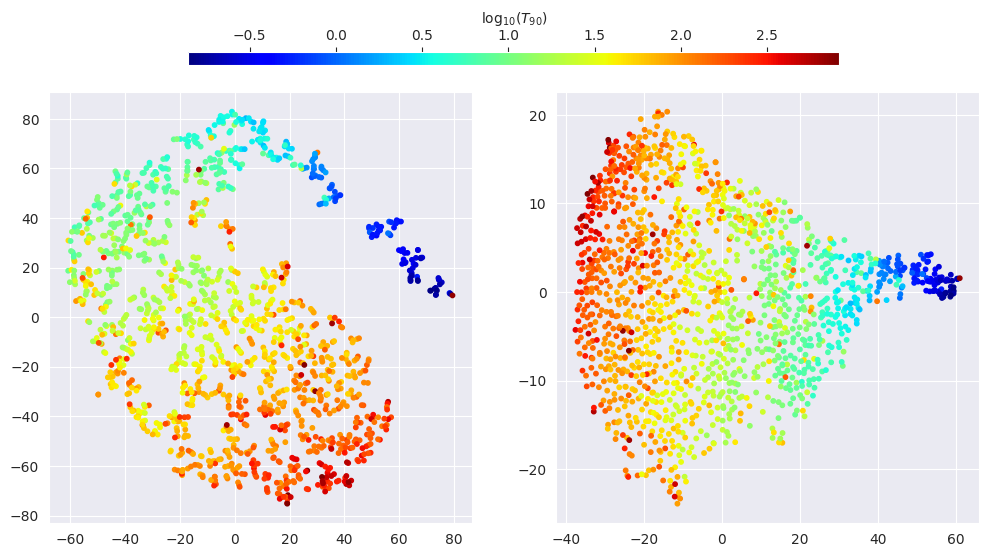

In [6]:
%matplotlib inline
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(ncols=2, nrows=1, wspace=0.2, hspace=0.2)
ax = gs.subplots()
for i, pos in enumerate(pos_64ms):
    ax[i], bar = swift.plot_tsne(pos, durations_64ms, ax=ax[i], return_colorbar=True, marker_size=10)
    bar.remove() if bar != () else None
    plt.axis('on')
# Add a shared color bar:
norm = mpl.colors.Normalize(vmin=min(np.log10(durations_64ms)), vmax=max(np.log10(durations_64ms)))
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet), ax=ax[:], location='top', label=r'log$_{10}\left(T_{90}\right)$', shrink=0.7, aspect=50)

Although it is less evident in the case with $perplexity=30$ (right panel of the figure), the GRBs are divided into two groups with a different range of $T_{90}$.

In this way, it is possible to classify GRBs into two groups: short GRBs (SGRBs) and long GRBs (LGRBs). To make this classification, it is possible to use the `split_points` instance of **ClassiPyGRB**. By using this function, it is possible to extract the names of GRBs in each group by using two approaches:

1. Separating groups by using a (x,y) limits: You can divide the plot in 4 quadrants using a horizontal line at $y$ and a vertical line at $x$, then you can specify which quadrant you need to use to separate groups.
2. Using a line passing in two points $(x_1, y_1)$ and $(x_2, y_2)$: A more general approach is divide the entire plot by using a line separating the two subgroups, you have to pass $(x_1, x_2)$ as `x_s` and $(y_1, y_2)$ as `y_s`.

In this case, we'll be using the first option:

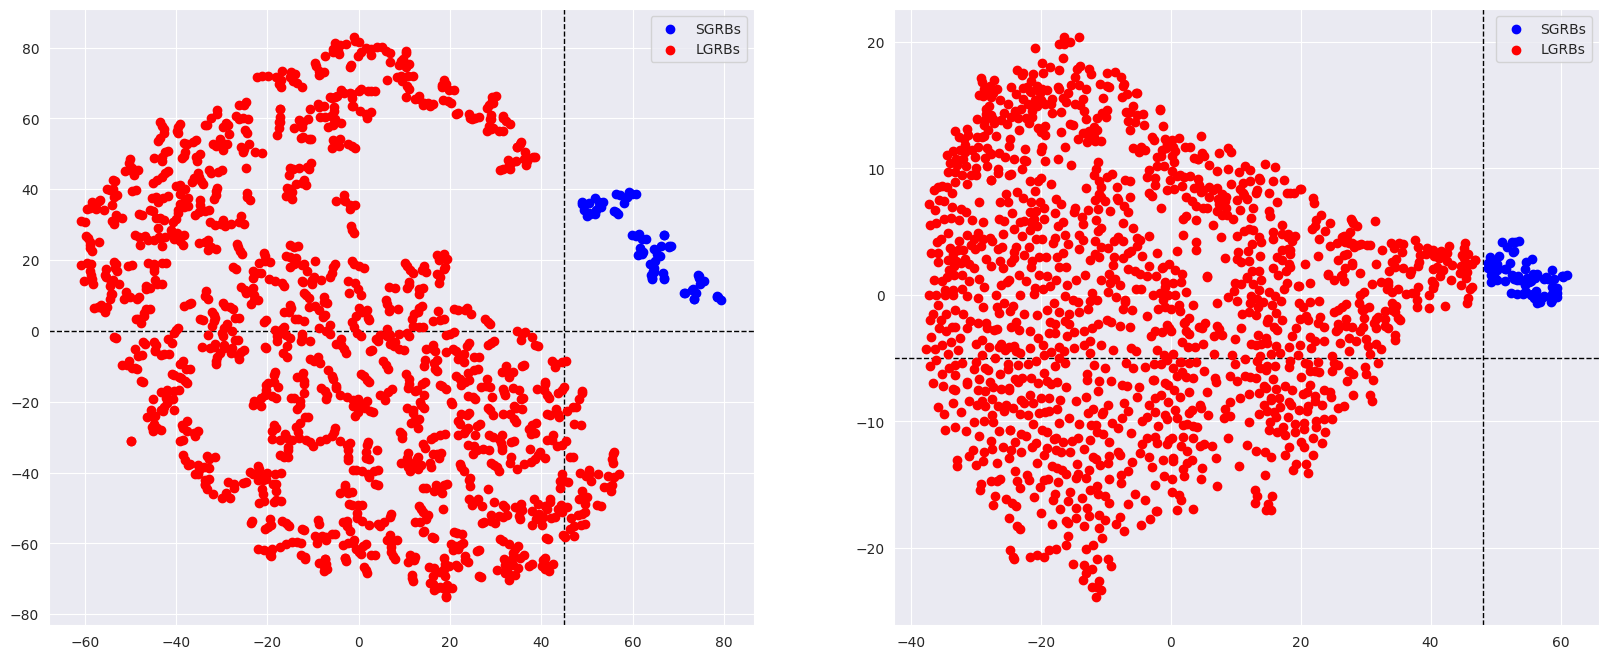

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# First case
group1, group2 = swift.split_points(pos_64ms[0], x_s=45, y_s=0, quadrant=1)  # Split points in quadrant 1 of x=50 and y=0 divisions
ax[0].axvline(x=45, c='k', ls='--', linewidth=1)
ax[0].axhline(y=0, c='k', ls='--', linewidth=1)
ax[0].scatter(group1[:, 0], group1[:, 1], c='b', label='SGRBs', zorder=10)
ax[0].scatter(group2[:, 0], group2[:, 1], c='r', label='LGRBs', zorder=10)
ax[0].legend()

# Second case
group3, group4 = swift.split_points(pos_64ms[1], x_s=48, y_s=-5)  # Split points in quadrant 1 of x=45 and y=0 divisions
ax[1].axvline(x=48, c='k', ls='--', linewidth=1)
ax[1].axhline(y=-5, c='k', ls='--', linewidth=1)
ax[1].scatter(group3[:, 0], group3[:, 1], c='b', label='SGRBs', zorder=10)
ax[1].scatter(group4[:, 0], group4[:, 1], c='r', label='LGRBs', zorder=10)
ax[1].legend()

As you can see, these function adequately works to divide the GRBs into two groups. Now, it is time to show the distribution of duration and hardness_ratio for each group.

## Duration distribution

In order to compare with previous results, we created the `duration_histogram` function to replicate the histograms of durations from other facilities such as BATSE and Fermi/GBM. This function takes the names of GRBs in each group as unique mandatory argument, and optionally can receive the durations' interval, the colours of each group in the histogram and additional kwargs of the `matplotlib.axes.Axes.hist` function:

Finding Durations: 100%|██████████| 1380/1380 [00:00<00:00, 1581.25GRB/s]


Text(0, 0.5, 'Number of GRBs')

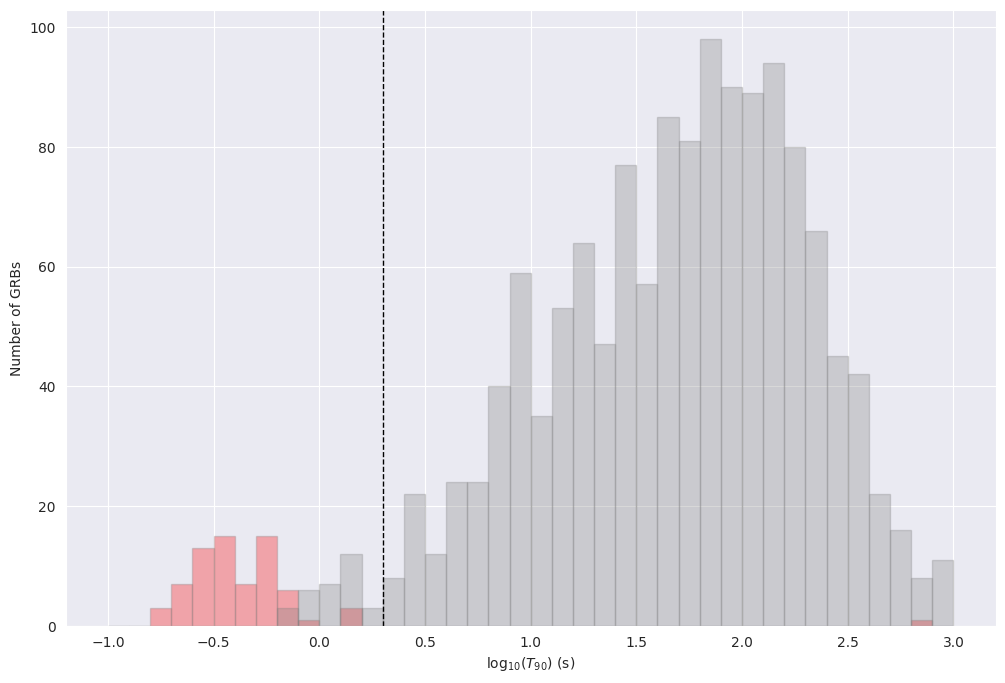

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
match = np.unique(np.where(np.isin(pos_64ms[0], group1))[0])
match2 = np.unique(np.where(np.isin(pos_64ms[0], group2))[0])
names1 = names_64ms[match]
names2 = names_64ms[match2]
swift.duration_histogram(names=[names1, names2], alpha=0.3, color_groups=['r', 'gray'], ax=ax)
ax.axvline(x=np.log10(2), c='k', ls='--', linewidth=1)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel('Number of GRBs')

As you can see, the distribution of $T_{90}$ is different for each group. On this notebook, there are 71 SGRBs and 1380 LGRBs classified by using the t-SNE technique. These groups are the same in the case of $perplexity=5$ and $perplexity=30$.

Here, we highlight that t-SNE only needs the Fourier Spectrum of each one of the light curves of Swift/BAT. As result, this tool is able to classify GRBs in two groups with different duration distributions without using any other information or human prior knowledge.

## Hardness ratio distribution

To estimate the hardness ratio, **ClassiPyGRB** uses a proxy based on the ratio of the flux in $50-100$ keV and $25-50$ keV bands ([Jespersen et al. 2020](https://iopscience.iop.org/article/10.3847/2041-8213/ab964d)).

To find the flux in both bands, **ClassiPyGRB** uses the `swift.get_flux` function, which takes the name of the GRB as unique mandatory argument, and optionally can receive the energy band (`band`) and if you want to calculate the flux between some limits (`t` and `limits`, same args as `lc_limiter` instance). Consider the following example:

In [9]:
example = 'GRB060614'
flux = swift.get_flux(example, band=3, t=None, limits=[-1, 100])
print(f'Flux in 50-100 keV band: {flux:.3}')

Flux in 50-100 keV band: 7.12


On the other hand, to get the hardness ratio, you can use the `hardness_ratio` instance of `SWIFT`, which takes the name or names of GRBs as the unique mandatory argument. The same example as before:

In [10]:
hardness = swift.hardness_ratio(example)
print(f'Hardness ratio: {hardness:.3}')

Hardness ratio: 0.547


Now, let's see the distribution of hardness ratio for each group. To do this, we use the `hardness_ratio` instance over all short and long GRBs and plot the density map:

In [11]:
short_durations = swift.total_durations(names1, t=90)
short_hardness = swift.hardness_ratio(names1)
df_short = pd.DataFrame({'name': names1, 'T_90': short_durations, 'logT_90':np.log10(short_durations), 'hardness': short_hardness})
print(df_short.round(3))

Finding Durations: 100%|██████████| 71/71 [00:00<00:00, 1376.31GRB/s]


          name   T_90  logT_90  hardness
0    GRB050813  0.384   -0.416     0.743
1    GRB060801  0.504   -0.298     1.577
2    GRB061217  0.224   -0.650     1.558
3    GRB070406  0.816   -0.088     0.829
4   GRB070429B  0.488   -0.312     0.720
..         ...    ...      ...       ...
66  GRB201221D  0.164   -0.785     0.826
67  GRB210323A  1.120    0.049     0.737
68  GRB210726A  0.384   -0.416     0.849
69  GRB210919A  0.164   -0.785     0.859
70  GRB220412B  0.140   -0.854     0.806

[71 rows x 4 columns]


In [12]:
long_durations = swift.total_durations(names2, t=90)
long_hardness = swift.hardness_ratio(names2)
df_long = pd.DataFrame({'Name': names2, 'T_90': long_durations, 'logT_90': np.log10(long_durations), 'hardness': long_hardness})

Finding Durations: 100%|██████████| 1380/1380 [00:00<00:00, 1531.81GRB/s]


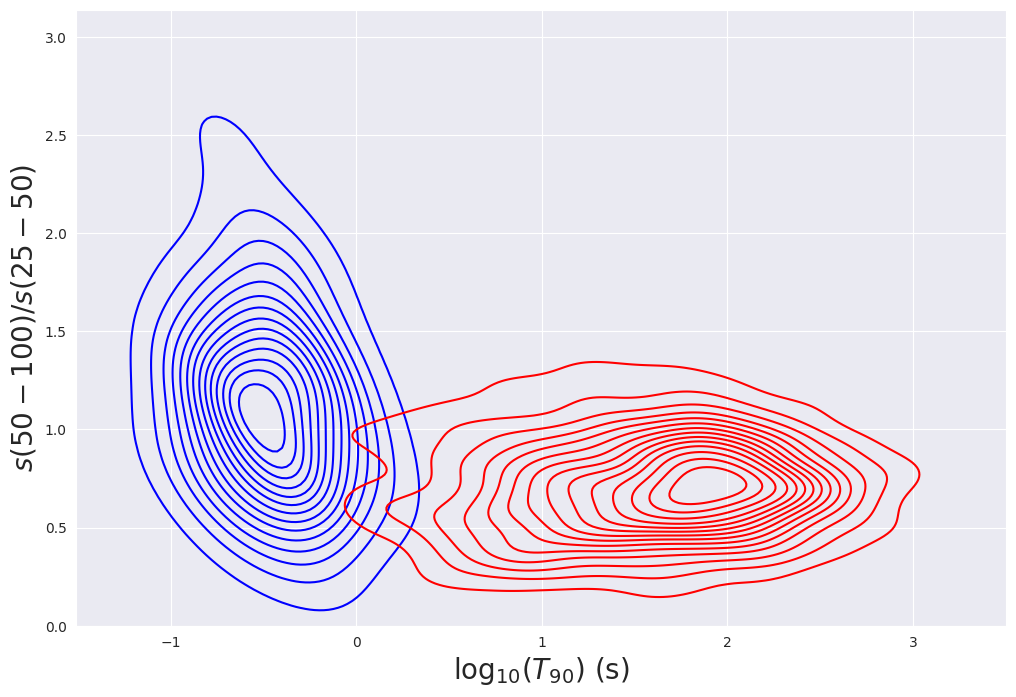

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.kdeplot(data=df_short, y='hardness', x='logT_90', ax=ax, levels=15, color="blue")
sns.kdeplot(data=df_long, y='hardness', x='logT_90', ax=ax, levels=15, color='red')
ax.set_ylim(bottom=0)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)').set_fontsize(20)
ax.set_ylabel(r'$s(50-100)/s(25-50)$').set_fontsize(20)

The distribution of hardness ratio appears very similar to the Figure 8 presented by [Steinhardt et al.(2023)](https://iopscience.iop.org/article/10.3847/1538-4357/acb999).  t-SNE is able to separate bursts with similar bulk properties, replicating a very well known result: the group of long GRBs are softer and longer than short GRBs, with some overlapping in the middle of the plot.

Finally, the evidence presented through this notebook shows that the groups isolated by this technique are not merely a coincidence or a pipeline or spurious result, but a real separation of GRBs with different properties.

# Noise removal analysis

We showed in the previous section that t-SNE is able to discern about two distinct classes of GRBs only by using the Fourier Amplitude Spectrum of Swift/BAT light curves. However, the distribution of durations does not show a cut-off at $T_{90} = 2$ s (as a standard value used in the separation of the two populations), at least for 64 ms binning data.

In order to get a more reliable classification, this section presents an analysis of noise-reduced light curves of Swift/BAT using t-SNE as a dimensionality reduction technique. This notebook is based on the results presented by [Garcia-Cifuentes et al.(2023)](https://arxiv.org/abs/2304.08666).

## Noise approach: Use 10s binning data

One approach to reduce noise is to use a larger binning time. In the [Interpolation notebook](https://github.com/KenethGarcia/ClassiPyGRB/blob/217a0953bb17f9742b923361d2c8dca36814b3e1/docs/5.BAT_Interpolate.ipynb), we interpolated data at 10s binning to get a standard set of light curves in the temporal axis. In this section, we analyze the results obtained.

First, we have to create a `SWIFT` instance with the same parameters as the interpolation notebook:

In [14]:
swift = SWIFT(root_path=r'put-your-path-here', res=10000, n_bands=[1, 2, 3, 4, 5])
print(f"Swift/BAT bands selected: {swift.bands_selected}")

Swift/BAT bands selected: ['Time(s)', '15-25keV', '25-50keV', '50-100keV', '100-350keV', '15-350keV']


load the preprocessed data obtained in the Interpolation notebook:

In [15]:
resolution = 30
data_10s = np.load(os.path.join(swift.results_path, f'SWIFT_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True_Interpolated_at_{resolution}ms.npz'))
names_10s, features_10s = data_10s['names'], data_10s['data']
durations_10s = swift.total_durations(names_10s, t=90)

Finding Durations: 100%|██████████| 1326/1326 [00:00<00:00, 1595.80GRB/s]


The current most used classification is based on duration, with a cut-off in 2s. Based on this scheme, we will have:

In [39]:
long_GRBs_10s = len(durations_10s[np.where(durations_10s <= 2)])
short_GRBs_10s = len(durations_10s[np.where(durations_10s > 2)])
print(f"At 10s, there are {long_GRBs_10s} long GRBs ({(long_GRBs_10s/len(durations_10s))*100:.2f}%) and {short_GRBs_10s} short GRBs ({(short_GRBs_10s/len(durations_10s))*100:.2f}%)")

At 10s, there are 38 long GRBs (2.87%) and 1288 short GRBs (97.13%)


Now, make a t-SNE embedding of the Fourier Amplitude Spectrum, using $5$ and $30$ as perplexity values:

In [17]:
%%time
pos_10s = [swift.perform_tsne(features_10s, perplexity=pp, learning_rate=200) for pp in [5, 30]]

CPU times: user 3min 18s, sys: 45.9 s, total: 4min 4s
Wall time: 45.9 s


Plotting the results, we obtain:

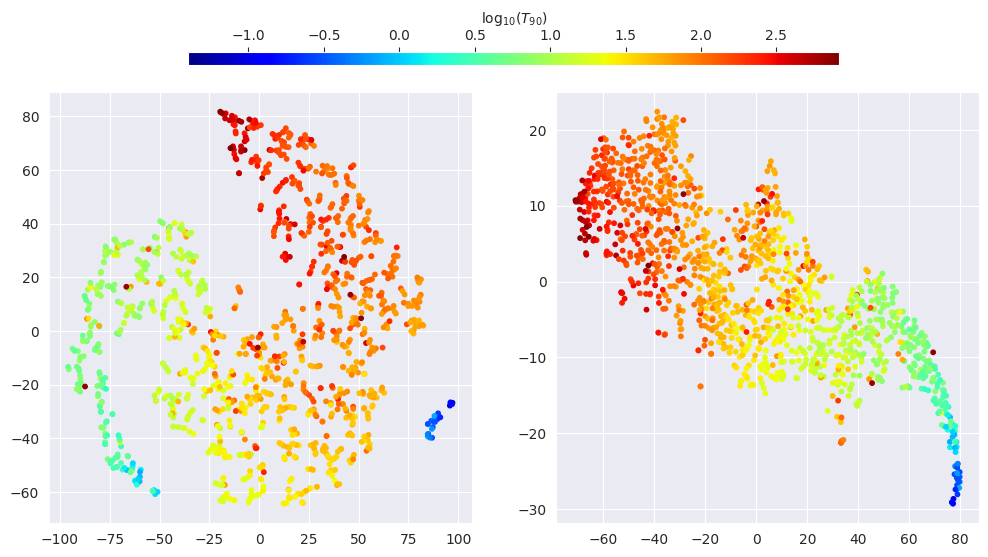

In [18]:
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(ncols=2, nrows=1, wspace=0.2, hspace=0.2)
ax = gs.subplots()
for i, pos in enumerate(pos_10s):
    ax[i], bar = swift.plot_tsne(pos, durations_10s, ax=ax[i], return_colorbar=True, marker_size=10)
    bar.remove() if bar != () else None
    plt.axis('on')
# Add a shared color bar:
norm = mpl.colors.Normalize(vmin=min(np.log10(durations_10s)), vmax=max(np.log10(durations_10s)))
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet), ax=ax[:], location='top', label=r'log$_{10}\left(T_{90}\right)$', shrink=0.7, aspect=50)

The use of noise-reduced datasets has some trade-offs
depending on the underlying nature of the reducing process In this case, the short GRB subgroup is less evident due to the decrease of GRBs with $T_{90} < 2$ s in the dataset (estimated at $~35\%$ by [Garcia-Cifuentes et al.(2023)](https://arxiv.org/abs/2304.08666)). However, the long GRB subgroup can be discerned, and there are a tight separation between the two subgroups:

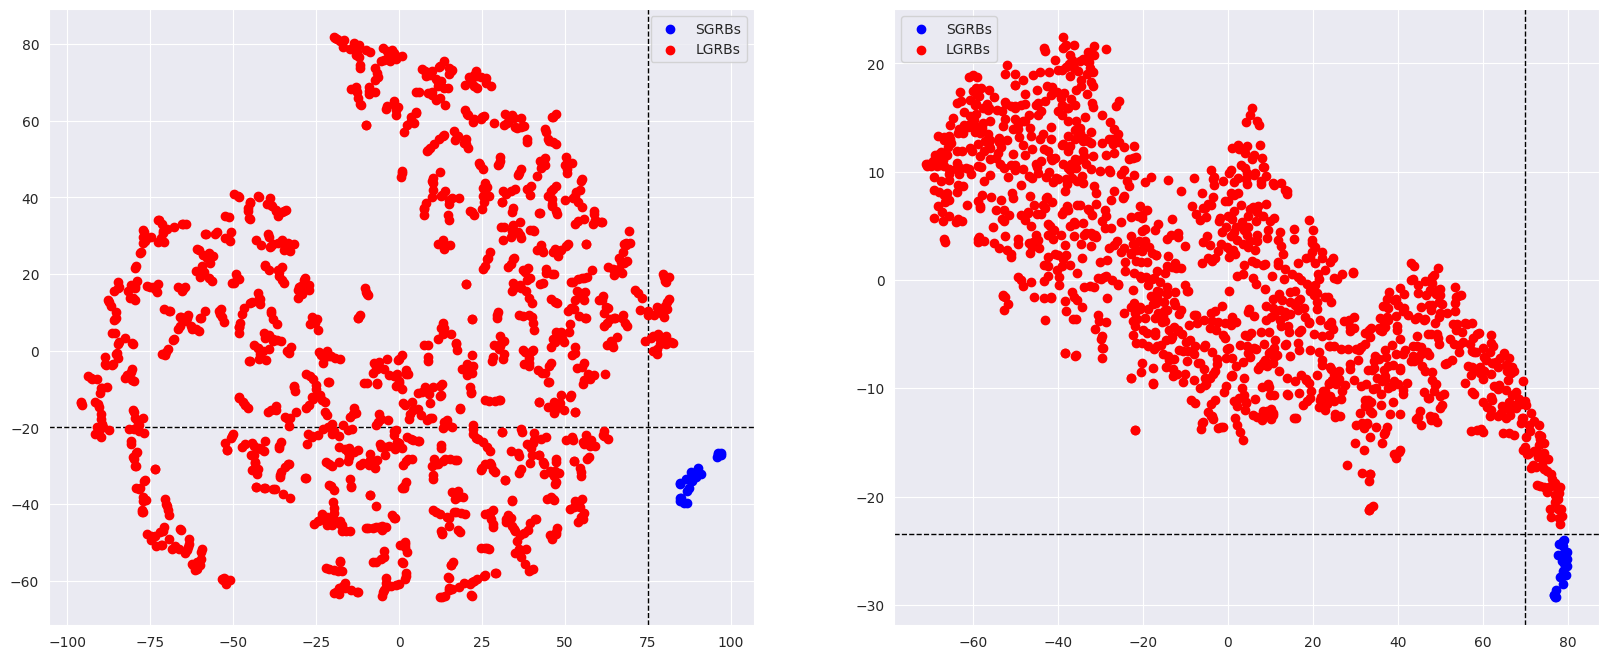

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# First case
group1, group2 = swift.split_points(pos_10s[0], x_s=75, y_s=-20, quadrant=4)  # Split points in quadrant 4 of x=75 and y=-20 divisions
ax[0].axvline(x=75, c='k', ls='--', linewidth=1)
ax[0].axhline(y=-20, c='k', ls='--', linewidth=1)
ax[0].scatter(group1[:, 0], group1[:, 1], c='b', label='SGRBs', zorder=10)
ax[0].scatter(group2[:, 0], group2[:, 1], c='r', label='LGRBs', zorder=10)
ax[0].legend()

# Second case
group3, group4 = swift.split_points(pos_10s[1], x_s=70, y_s=-23.5, quadrant=4)  # Split points in quadrant 4 of x=60 and y=0 divisions
ax[1].axvline(x=70, c='k', ls='--', linewidth=1)
ax[1].axhline(y=-23.5, c='k', ls='--', linewidth=1)
ax[1].scatter(group3[:, 0], group3[:, 1], c='b', label='SGRBs', zorder=10)
ax[1].scatter(group4[:, 0], group4[:, 1], c='r', label='LGRBs', zorder=10)
ax[1].legend()

Once again, the classification based on both perplexities discern about the same subgroups of SGRBs and LGRBS. Now, let's see the distribution of $T_{90}$ obtained for the two subgroups:

Finding Durations: 100%|██████████| 1303/1303 [00:00<00:00, 1382.23GRB/s]


Text(0, 0.5, 'Number of GRBs')

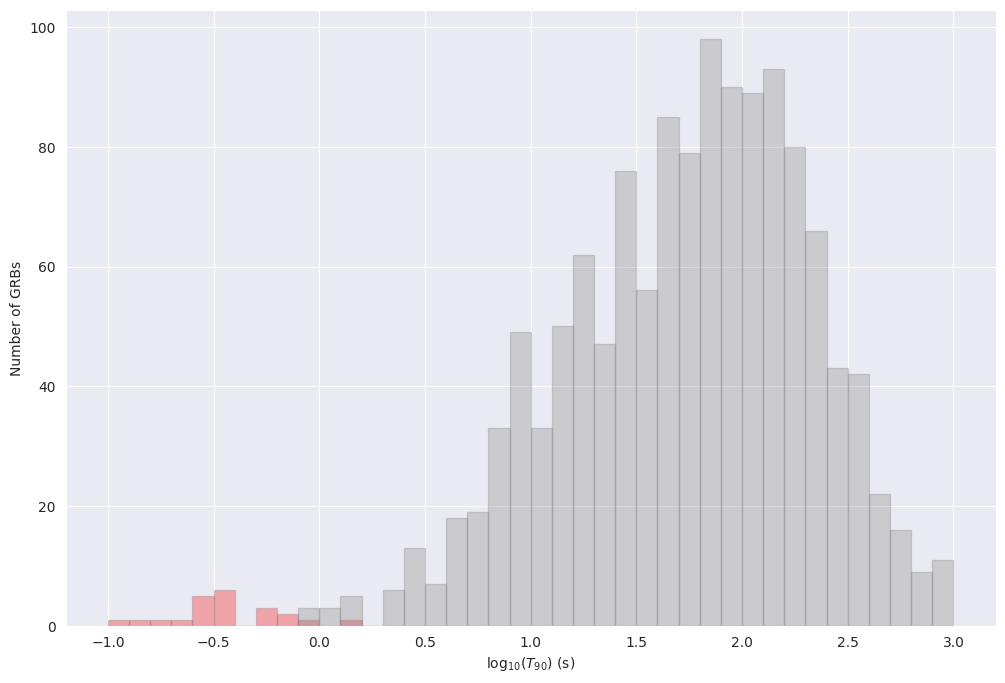

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
match = np.unique(np.where(np.isin(pos_10s[0], group1))[0])
match2 = np.unique(np.where(np.isin(pos_10s[0], group2))[0])
names1 = names_10s[match]
names2 = names_10s[match2]
swift.duration_histogram(names=[names1, names2], alpha=0.3, color_groups=['r', 'gray'], ax=ax)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel('Number of GRBs')

The distribution of $T_{90}$ is different for each group. In this case, there are only 23 SGRBs and 1303 LGRBs classified by using the t-SNE technique. These groups are the same in the case of $perplexity=5$ and $perplexity=30$.

Regarding the hardness ratio, **ClassiPyGRB** uses a proxy based on the ratio of the flux in $50-100$ keV and $25-50$ keV bands ([Jespersen et al. 2020](https://iopscience.iop.org/article/10.3847/2041-8213/ab964d)). To calculate the hardness ratio, you can use the `hardness_ratio` instance of `SWIFT`, which takes the name or names of GRBs as unique mandatory argument. The hardness ratio at 10s binning takes the form:

In [21]:
short_durations = swift.total_durations(names1, t=90)
short_hardness = swift.hardness_ratio(names1)
df_short = pd.DataFrame({'name': names1, 'T_90': short_durations, 'logT_90':np.log10(short_durations), 'hardness': short_hardness})
print(df_short.round(3))

Finding Durations: 100%|██████████| 23/23 [00:00<00:00, 1262.44GRB/s]


          name   T_90  logT_90  hardness
0    GRB061201  0.776   -0.110     1.363
1    GRB070923  0.040   -1.398     1.493
2   GRB091109B  0.272   -0.565     1.127
3   GRB100625A  0.332   -0.479     1.157
4   GRB120305A  0.100   -1.000     0.860
5   GRB130603B  0.176   -0.754     1.110
6   GRB130912A  0.284   -0.547     1.176
7   GRB140414A  0.496   -0.305     1.936
8   GRB140903A  0.296   -0.529     0.501
9   GRB141212A  0.288   -0.541     0.909
10  GRB150120A  1.196    0.078     0.650
11  GRB160408A  0.320   -0.495     1.428
12  GRB160525B  0.292   -0.535     0.777
13  GRB160612A  0.248   -0.606     1.127
14  GRB160726A  0.728   -0.138     1.249
15  GRB160927A  0.488   -0.312     0.955
16  GRB161104A  0.100   -1.000     0.903
17  GRB170428A  0.200   -0.699     1.275
18  GRB191031D  0.288   -0.541     1.260
19  GRB200522A  0.616   -0.210     0.754
20  GRB201006A  0.492   -0.308     0.536
21  GRB201221D  0.164   -0.785     1.266
22  GRB220412B  0.140   -0.854     0.915


In [22]:
long_durations = swift.total_durations(names2, t=90)
long_hardness = swift.hardness_ratio(names2)
df_long = pd.DataFrame({'Name': names2, 'T_90': long_durations, 'logT_90': np.log10(long_durations), 'hardness': long_hardness})
print(df_long.round(3))

Finding Durations: 100%|██████████| 1303/1303 [00:00<00:00, 1366.51GRB/s]


            Name     T_90  logT_90  hardness
0      GRB041217    5.668    0.753     0.873
1     GRB041219C   10.000    1.000     0.608
2      GRB041220    5.584    0.747     0.615
3      GRB041223  109.060    2.038     1.004
4      GRB041224  177.564    2.249     0.656
...          ...      ...      ...       ...
1298  GRB220701A   13.524    1.131     0.426
1299  GRB220706A   85.996    1.934     0.574
1300  GRB220711B   87.056    1.940     0.634
1301  GRB220714B   49.040    1.691     0.584
1302  GRB220715B   40.408    1.606     0.809

[1303 rows x 4 columns]


Text(0, 0.5, '$s(50-100)/s(25-50)$')

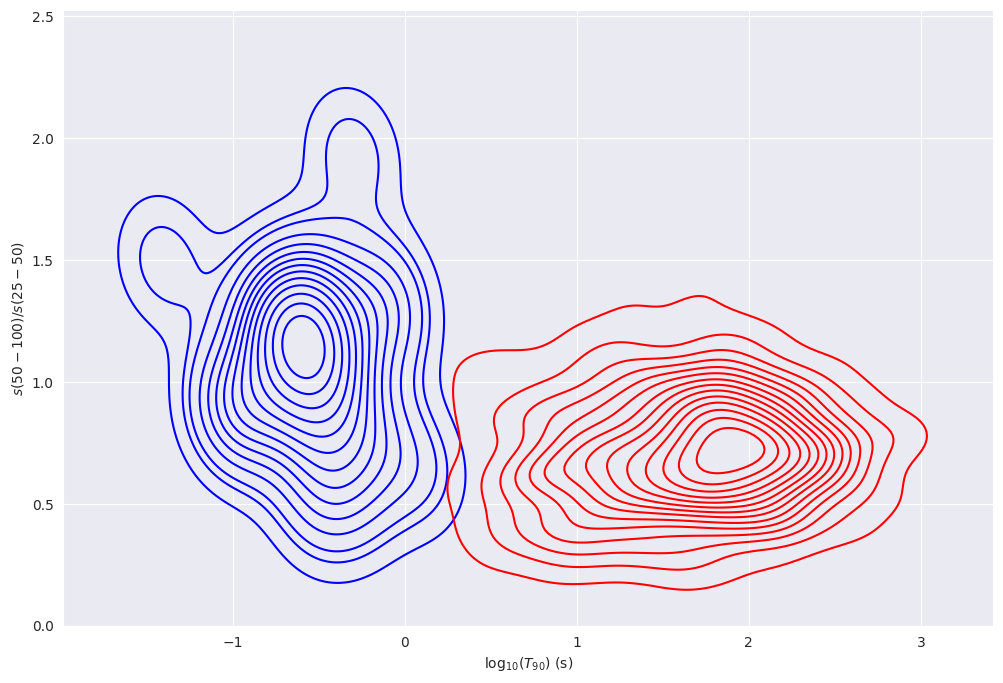

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.kdeplot(data=df_short, y='hardness', x='logT_90', ax=ax, levels=15, color="blue")
sns.kdeplot(data=df_long, y='hardness', x='logT_90', ax=ax, levels=15, color='red')
ax.set_ylim(bottom=0)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel(r'$s(50-100)/s(25-50)$')

The results obtained are very similar to the hardness ratio distributed in the 64 ms binning case. t-SNE is able to separate bursts with different properties: a group of long GRBs with softer and longer durations than short GRBs.

## Noise approach: FABADA

Another approach to reduce noise is by using the non-parametric reduction technique stated in [FABADA](https://github.com/PabloMSanAla/fabada). In the [Noise Reduction notebook](https://github.com/KenethGarcia/ClassiPyGRB/blob/599059d8d7cfa2d66f61b97b86d0eedc706c652e/docs/4.BAT_Noise_Reduction.ipynb), we used FABADA to obtain low signal-to-noise ratio light curves from Swift/BAT. In this section, we are going to analyze the results obtained.

First, we modify `SWIFT` resolution attribute from 10 s to 64 ms:

In [26]:
swift_2 = SWIFT(root_path=r'test-your-path-here', res=64, n_bands=[1, 2, 3, 4, 5])
print(f"Swift/BAT bands selected: {swift_2.bands_selected}")
old_path = swift_2.original_data_path
swift_2.original_data_path = swift_2.noise_data_path
print(f"Resolution: {swift_2.res} ms")

Swift/BAT bands selected: ['Time(s)', '15-25keV', '25-50keV', '50-100keV', '100-350keV', '15-350keV']
Resolution: 64 ms


Now, we load the preprocessed data obtained in the FABADA noise reduction notebook:

In [27]:
data_fabada = np.load(os.path.join(swift_2.results_path, f'SWIFT_Noise_Reduced_data_{swift_2.res}res_{"".join(str(b) for b in swift_2.n_bands)}bands_DFT_True.npz'))
names_fabada, features_fabada = data_fabada['names'], data_fabada['data']
durations_fabada = swift_2.total_durations(names_fabada, t=90)

Finding Durations: 100%|██████████| 1451/1451 [00:01<00:00, 999.20GRB/s] 


Make t-SNE embeddings for the FABADA noise reduced case:

In [28]:
%%time
pos_fabada = [swift_2.perform_tsne(features_fabada, perplexity=pp, learning_rate=200) for pp in [5, 30]]

CPU times: user 2min 30s, sys: 33.4 s, total: 3min 4s
Wall time: 34.5 s


Plotting results:

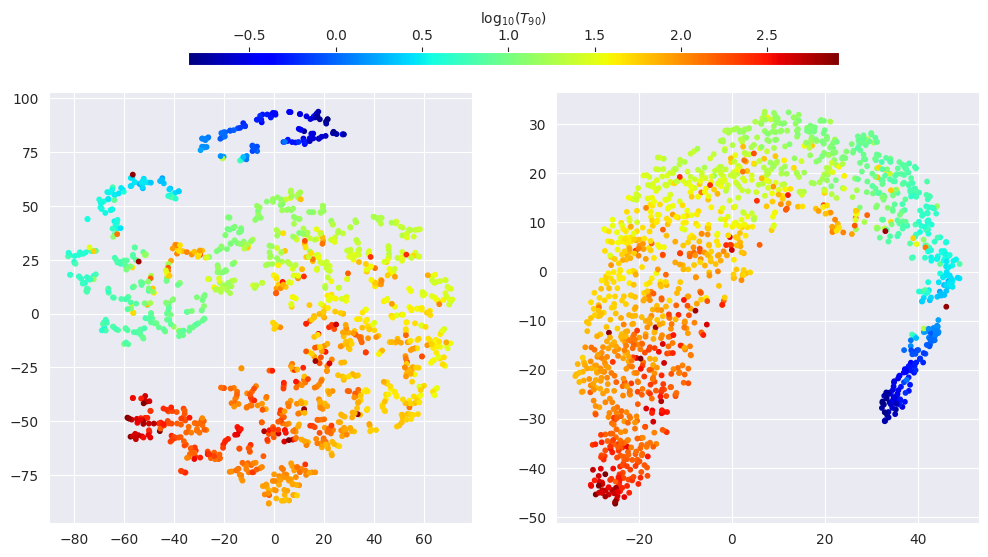

In [29]:
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(ncols=2, nrows=1, wspace=0.2, hspace=0.2)
ax = gs.subplots()
for i, pos in enumerate(pos_fabada):
    ax[i], bar = swift_2.plot_tsne(pos, durations_fabada, ax=ax[i], return_colorbar=True, marker_size=10)
    bar.remove() if bar != () else None
    plt.axis('on')
# Add a shared color bar:
norm = mpl.colors.Normalize(vmin=min(np.log10(durations_fabada)), vmax=max(np.log10(durations_fabada)))
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet), ax=ax[:], location='top', label=r'log$_{10}\left(T_{90}\right)$', shrink=0.7, aspect=50)

These results are very similar to the 64 ms binning case: t-SNE is able to separate bursts with different properties: a group of long GRBs with softer and longer durations than short GRBs. However, the short GRB group have more bursts than the case without FABADA noise reducing technique:

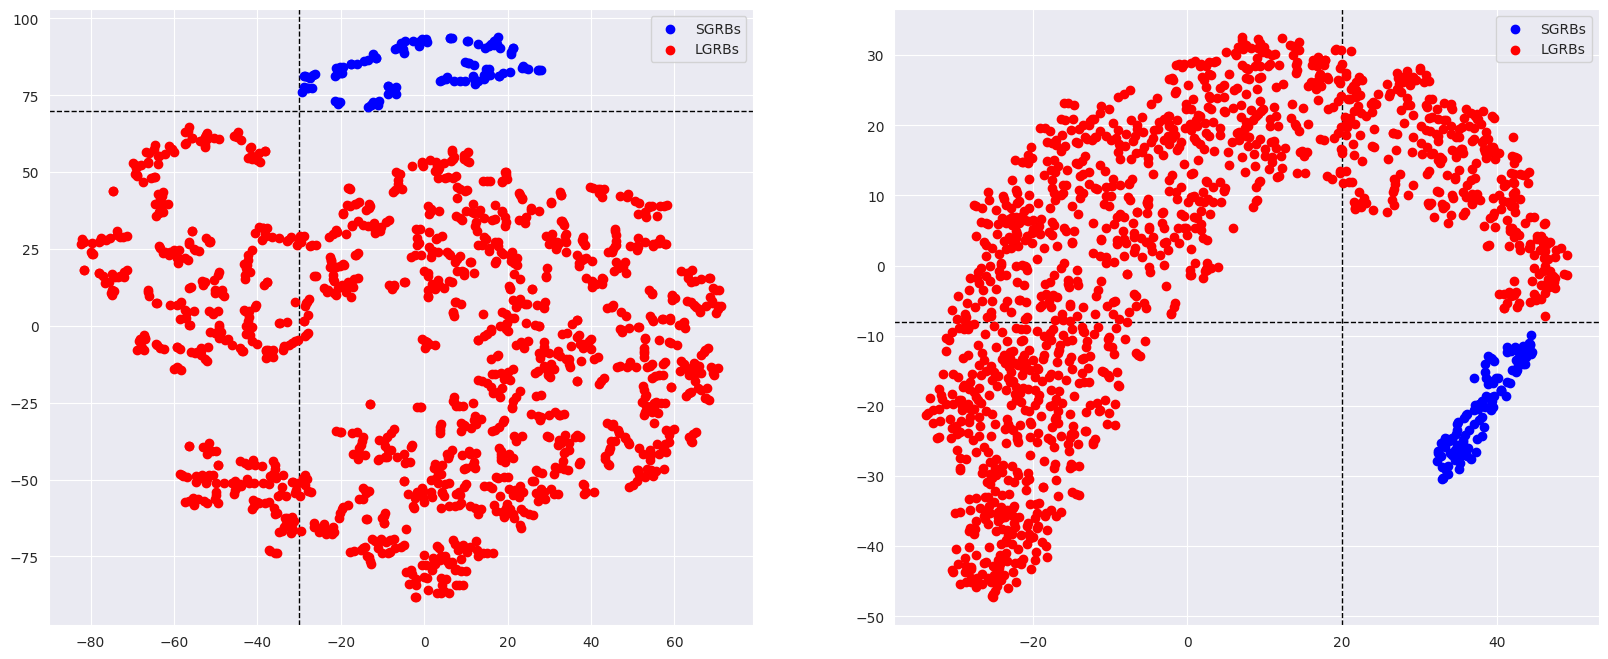

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
# First case
group1, group2 = swift_2.split_points(pos_fabada[0], x_s=-30, y_s=70, quadrant=1)
ax[0].axvline(x=-30, c='k', ls='--', linewidth=1)
ax[0].axhline(y=70, c='k', ls='--', linewidth=1)
ax[0].scatter(group1[:, 0], group1[:, 1], c='b', label='SGRBs', zorder=10)
ax[0].scatter(group2[:, 0], group2[:, 1], c='r', label='LGRBs', zorder=10)
ax[0].legend()
# Second case
group3, group4 = swift_2.split_points(pos_fabada[1], x_s=20, y_s=-8, quadrant=4)
ax[1].axvline(x=20, c='k', ls='--', linewidth=1)
ax[1].axhline(y=-8, c='k', ls='--', linewidth=1)
ax[1].scatter(group3[:, 0], group3[:, 1], c='b', label='SGRBs', zorder=10)
ax[1].scatter(group4[:, 0], group4[:, 1], c='r', label='LGRBs', zorder=10)
ax[1].legend()

This result represent one of the most important abstraction about model-independent classifications: data analysis models as t-SNE are strongly influenced by the presence of noise ([Garcia-Cifuentes et al.2023](https://arxiv.org/abs/2304.08666)). The effective population of short GRBs is dramatically decreased by the presence of noise. This is a very important result to bear in mind when we are going to use model-independent techniques to classify GRBs.

We can also plot the duration histogram for the groups separated in FABADA noise reduced case:

Finding Durations: 100%|██████████| 1342/1342 [00:00<00:00, 1587.26GRB/s]


Text(0, 0.5, 'Number of GRBs')

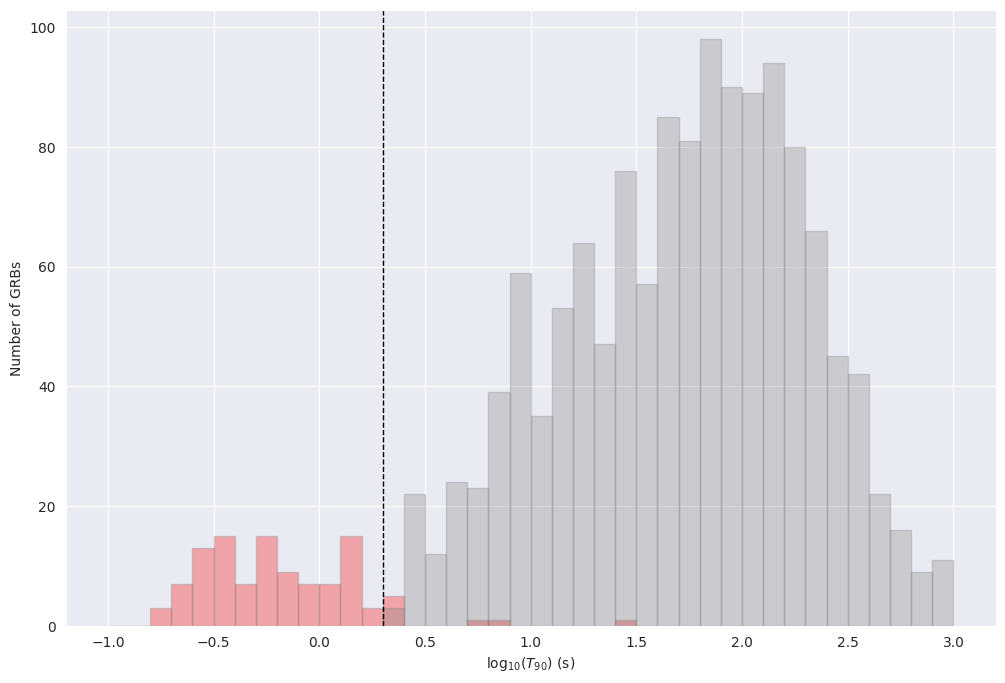

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
match = np.unique(np.where(np.isin(pos_fabada[0], group1))[0])
match2 = np.unique(np.where(np.isin(pos_fabada[0], group2))[0])
names1 = names_fabada[match]
names2 = names_fabada[match2]
swift_2.duration_histogram(names=[names1, names2], alpha=0.3, color_groups=['r', 'gray'], ax=ax)
ax.axvline(x=np.log10(2), c='k', ls='--', linewidth=1)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel('Number of GRBs')

Short GRBs are more spread over the range of durations, compared with the case of 64 ms binning data without FABADA noise reducing. Using these technique as a previous step to the classification process, it is possible to reach an usual classification scheme: the cut-off between short and long GRBs defined at $T_{90} = 2$ s (black dashed line).

Now, regarding the hardness ratio, we can plot the hardness ratio histogram for the groups separated in FABADA noise reduced case (here we are going to use the original 64 ms data to obtain the fluxes):

In [32]:
swift_2.original_data_path = old_path
short_durations = swift_2.total_durations(names1, t=90)
short_hardness = swift_2.hardness_ratio(names1)
df_short = pd.DataFrame({'name': names1, 'T_90': short_durations, 'logT_90':np.log10(short_durations), 'hardness': short_hardness})
print(df_short.round(3))

Finding Durations: 100%|██████████| 109/109 [00:00<00:00, 1481.22GRB/s]


           name   T_90  logT_90  hardness
0     GRB050813  0.384   -0.416     0.743
1     GRB051210  1.300    0.114     1.095
2    GRB051221A  1.392    0.144     0.917
3     GRB060313  0.744   -0.128     1.393
4     GRB060801  0.504   -0.298     1.577
..          ...    ...      ...       ...
104  GRB210323A  1.120    0.049     0.737
105  GRB210726A  0.384   -0.416     0.849
106  GRB210919A  0.164   -0.785     0.859
107  GRB211023B  1.300    0.114     0.464
108  GRB220412B  0.140   -0.854     0.806

[109 rows x 4 columns]


In [33]:
long_durations = swift_2.total_durations(names2, t=90)
long_hardness = swift_2.hardness_ratio(names2)
df_long = pd.DataFrame({'Name': names2, 'T_90': long_durations, 'logT_90': np.log10(long_durations), 'hardness': long_hardness})
print(df_long.round(3))

Finding Durations: 100%|██████████| 1342/1342 [00:01<00:00, 985.98GRB/s] 


            Name     T_90  logT_90  hardness
0      GRB041217    5.668    0.753     0.862
1     GRB041219C   10.000    1.000     0.577
2      GRB041220    5.584    0.747     0.618
3      GRB041223  109.060    2.038     1.002
4      GRB041224  177.564    2.249     0.645
...          ...      ...      ...       ...
1337  GRB220706A   85.996    1.934     0.573
1338  GRB220708A    4.000    0.602     0.305
1339  GRB220711B   87.056    1.940     0.614
1340  GRB220714B   49.040    1.691     0.564
1341  GRB220715B   40.408    1.606     0.749

[1342 rows x 4 columns]


Text(0, 0.5, '$s(50-100)/s(25-50)$')

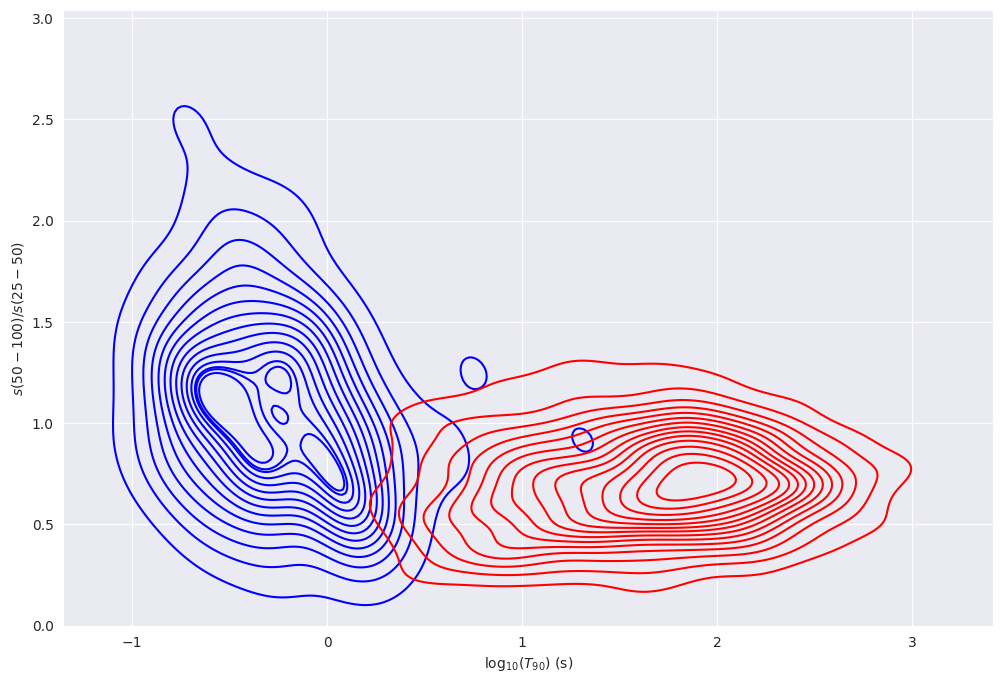

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.kdeplot(data=df_short, y='hardness', x='logT_90', ax=ax, levels=15, color="blue")
sns.kdeplot(data=df_long, y='hardness', x='logT_90', ax=ax, levels=15, color='red')
ax.set_ylim(bottom=0)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel(r'$s(50-100)/s(25-50)$')

The distribution of hardness ratio follows the same behavior as the case without FABADA noise reducing technique and the 10 s binning data: typically, short GRBs are harder than long GRBs.

# Summary

This table summarizes the results obtained in this notebook:

In [41]:
df = pd.DataFrame({
    "SGRBs": [108, 71, 109, 38, 23],
    "Size (%s)": [7.44, 4.89, 7.51, 2.86, 1.73],
    "Diff (%s)": [0, 34.26, 0.92, 0, 39.47],
    "LGRBs": [1343, 1380, 1342, 1288, 1303],
    "Size (%l)": [92, 95.11, 92.49, 97.13, 98.26],
    "Diff (%l)": [0, 2.75, 0.074, 0, 1.16]
}, index=["Most Used 64ms", "TSNE 64ms", "TSNE FABADA", "Most Used 10s", "TSNE 10s (30ms)"])
print(df)

                 SGRBs  Size (%s)  Diff (%s)  LGRBs  Size (%l)  Diff (%l)
Most Used 64ms     108       7.44       0.00   1343      92.00      0.000
TSNE 64ms           71       4.89      34.26   1380      95.11      2.750
TSNE FABADA        109       7.51       0.92   1342      92.49      0.074
Most Used 10s       38       2.86       0.00   1288      97.13      0.000
TSNE 10s (30ms)     23       1.73      39.47   1303      98.26      1.160
